# Reactor Kinetics Example 

Jialu Wang (jwang44@nd.edu) and Alex Dowling (adowling@nd.edu)

University of Notre Dame

This notebook conducts design of experiments for a reactor kinetics experiment with the Pyomo.DOE.
    

## Step 0: Import Pyomo and Pyomo.DOE module

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import idaes
import pyomo.environ as pyo
import fim_doe as doe
import pyomo.common.unittest as unittest

In [2]:
## check if ipopt available 

ipopt_available = pyo.SolverFactory('ipopt').available()

if not (ipopt_available):
    raise RuntimeError('Pyomo.DOE unit tests require IPOPT')

## Step 1: Import Reaction Example Mathematical Model

Consider two chemical reactions that convert molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$

Our ultimate goal is to design a large-scale continous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmasuticals, etc.).

The rate laws for these two chemical reactions are:

$r_A = -k_1 C_A$

$r_B = k_1 C_A - k_2 C_B$

$r_C = k_2 C_B$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$k_1 = A_1 \exp{\frac{-E_1}{R T}}$

$k_2 = A_2 \exp{\frac{-E_2}{R T}}$

$A_1, A_2, E_1$, and $E_2$ are fitted model parameters. $R$ is the ideal-gas constant and $T$ is absolute temperature.

Using the **CCSI$^2$ toolset**, we would like to perform **uncertainty quantification** and **design of experiments** on a small-scale **batch reactor** to infer parameters $A_1$, $A_2$, $E_1$, and $E_2$.

### Batch reactor

The concenration in a batch reactor evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

When the temperature is constant, it leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

In [3]:
# The model is implemented in reactor_kinetics.py 
from reactor_kinetics import create_model, disc_for_measure

## Step 2: Define inputs

In [4]:
# Create model function
createmod = create_model

# discretization by Pyomo.DAE
disc = disc_for_measure

# Control time set [h]
t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
    
# Measurement time points [h]
t_measure = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

# design variable and its control time set
dv_pass = {'CA0': [0],'T': t_control}
    
# Create measurement object
measure_pass = {'C':{'CA': t_measure, 'CB': t_measure, 'CC': t_measure}}
measure_class =  doe.Measurements(measure_pass)

# Define parameter nominal value 
parameter_dict = {'A1': 84.79085853498033, 'A2': 371.71773413976416, 'E1': 7.777032028026428, 'E2': 15.047135137500822}

In [5]:
def generate_exp(t_set, CA0, T):  
    """Generate experiments. 
    t_set: time control set for T.
    CA0: CA0 value
    T: A list of T 
    """
    assert(len(t_set)==len(T)), 'T should have the same length as t_set'
    
    T_con_initial = {}
    for t, tim in enumerate(t_set):
        T_con_initial[tim] = T[t]
        
    dv_dict_overall = {'CA0': {0: CA0},'T': T_con_initial}
    return dv_dict_overall

In [6]:
# empty prior
prior_all = np.zeros((4,4))
prior_pass=np.asarray(prior_all)

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigvals(prior_pass))

The prior information FIM: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Prior Det: 0.0
Eigenvalue of the prior experiments FIM: [0. 0. 0. 0.]


## Method: Compute FIM 

This method computes an MBDoE optimization problem with no Degree of Freedom.

In [7]:
# choose from 'sequential_finite', 'direct_kaug'
# 'sequential_sipopt', 'sequential_kaug' is also available
#sensi_opt = 'sequential_finite'
sensi_opt = 'direct_kaug'

# model option
if sensi_opt == 'direct_kaug':
    args_ = [False]
else:
    args_ = [True]
    

# Define experiments
exp1 = generate_exp(t_control, 5, [570, 300, 300, 300, 300, 300, 300, 300, 300])

In [8]:
doe_object = doe.DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=args_)


result = doe_object.compute_FIM(exp1, mode=sensi_opt, FIM_store_name = 'dynamic.csv', 
                                store_output = 'store_output', read_output=None,
                                formula='central')


result.calculate_FIM(doe_object.design_values)


After practice: {'C_index_CA': [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1], 'C_index_CB': [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1], 'C_index_CC': [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]}
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scien

In [9]:
print('======Result summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(result.trace))
print('D-optimality:', np.log10(result.det))
print('E-optimality:', np.log10(result.min_eig))
print('Modified E-optimality:', np.log10(result.cond))

======Result summary======
Four design criteria log10() value:
A-optimality: 0.4961362903000966
D-optimality: -10.311819128806142
E-optimality: -5.553639769002443
Modified E-optimality: 6.006360380270291


## Method: Optimization
Gradient-based optimization with IPOPT with .optimize_doe()

This function solves twice: It solves the square version of the MBDoE problem first, and then unfixes the design variables as degree of freedom and solves again. In this way the optimization problem can be well initialized. 

In [10]:
exp1 = generate_exp(t_control, 3, [300, 300, 300, 300, 300, 300, 300, 300, 300])

In [11]:
doe_object = doe.DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=[True])

square_result, optimize_result= doe_object.optimize_doe(exp1, if_optimize=True, if_Cholesky=True, 
                                                         scale_nominal_param_value=True, objective_option='det', 
                                                         L_initial=None)

Sensitivity information is scaled by its corresponding parameter nominal value.
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    conta

  16 -2.8030738e+01 1.63e+05 6.98e+14  -1.0 1.84e+01  13.6 1.00e+00 1.00e+00h  1
  17 -2.7223078e+01 1.62e+05 4.54e+14  -1.0 4.54e+00  14.0 1.00e+00 1.00e+00h  1
  18 -2.5094307e+01 1.60e+05 5.25e+14  -1.0 1.59e+01  13.5 1.00e+00 1.00e+00h  1
  19 -2.4168422e+01 1.59e+05 5.55e+14  -1.0 6.21e+00  14.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -2.1819801e+01 1.59e+05 4.79e+14  -1.0 1.58e+01  13.5 1.00e+00 1.00e+00h  1
  21 -2.1699782e+01 1.59e+05 4.66e+14  -1.0 5.07e+00  13.9 1.00e+00 1.25e-01h  4
  22r-2.1699782e+01 1.59e+05 1.00e+03   5.0 0.00e+00  13.4 0.00e+00 4.77e-07R 22
  23r-2.3136663e+01 1.57e+05 4.59e+04   5.0 2.70e+06    -  3.77e-05 1.61e-03f  1
  24r-2.4708287e+01 1.52e+05 4.47e+04   2.9 1.52e+06    -  1.92e-01 1.54e-02f  1
  25r-1.5454129e+01 1.52e+05 4.48e+04   2.9 1.18e+03   4.0 4.32e-01 2.12e-03h  1
  26r-1.4438657e+01 1.52e+05 5.49e+05   2.9 1.27e+03   3.5 3.33e-01 4.26e-02f  1
  27r-1.5313970e+01 1.51e+05

 114r-3.0687641e+01 6.04e+01 4.85e+02  -4.4 2.87e+03    -  1.00e+00 1.91e-01h  1
 115r-3.1113071e+01 5.05e+01 2.14e+02  -4.4 2.41e+03    -  9.31e-01 5.72e-01h  1
 116r-3.1579761e+01 2.98e+01 1.62e+00  -4.4 1.18e+03    -  1.00e+00 1.00e+00h  1
 117r-3.1657113e+01 9.94e-01 3.54e-03  -4.4 4.36e+01    -  1.00e+00 1.00e+00h  1
 118r-3.1657070e+01 1.21e-02 2.37e-07  -4.4 2.15e-01    -  1.00e+00 1.00e+00h  1
 119r-3.1658151e+01 1.23e-02 2.73e+00  -6.6 3.08e-01    -  7.78e-01 9.93e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120r-3.1795322e+01 9.55e+00 6.45e+01  -6.6 3.80e+04    -  1.81e-01 3.07e-02f  1
 121r-3.1882000e+01 1.29e+01 1.33e+02  -6.6 3.80e+04    -  2.32e-01 1.91e-02f  1
 122r-3.1898120e+01 1.30e+01 2.14e+02  -6.6 3.61e+04    -  3.67e-01 3.77e-03f  1
 123r-3.1927152e+01 1.29e+01 3.80e+02  -6.6 1.23e+04    -  2.17e-01 2.12e-02h  1
 124r-3.2248286e+01 1.92e+02 4.15e+02  -6.6 1.22e+04    -  4.21e-01 2.53e-01f  1
 125r-3.2311972e+01 1.91e+02

 251r-3.5348847e+01 1.50e+02 9.97e+02  -6.6 6.01e+03    -  5.41e-01 1.42e-02f  7
 252r-3.5348849e+01 1.50e+02 9.57e+02  -6.6 6.00e+03    -  1.00e+00 3.36e-06f  1
 253r-3.5356673e+01 1.48e+02 9.82e+02  -6.6 5.98e+03    -  7.91e-01 1.39e-02f  7
 254r-3.5356685e+01 1.48e+02 1.02e+03  -6.6 6.32e+03    -  3.40e-01 1.85e-05f  1
 255r-3.5367122e+01 1.46e+02 1.00e+03  -6.6 6.08e+03    -  1.00e+00 1.73e-02f  2
 256r-3.5374852e+01 1.44e+02 9.84e+02  -6.6 6.05e+03    -  1.00e+00 1.29e-02f  3
 257r-3.5386958e+01 1.41e+02 9.00e+02  -6.6 6.02e+03    -  1.00e+00 2.05e-02f  2
 258r-3.5394165e+01 1.39e+02 8.78e+02  -6.6 5.89e+03    -  1.00e+00 1.29e-02f  3
 259r-3.5404669e+01 1.37e+02 8.79e+02  -6.6 5.81e+03    -  4.75e-01 1.97e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260r-3.5814085e+01 4.36e+02 1.80e+02  -6.6 5.78e+03    -  7.33e-01 8.02e-01f  1
 261r-3.5814090e+01 4.36e+02 2.46e+02  -6.6 3.34e+03    -  7.31e-01 2.33e-05f  1
 262r-3.5815148e+01 4.34e+02

   1 -3.6072890e+01 3.28e+04 1.41e+01  -1.0 1.77e+05    -  7.98e-01 2.13e-01h  3
   2 -2.4572931e+01 4.05e+05 2.64e+02  -1.0 5.58e+05    -  4.72e-01 7.17e-01f  1
   3 -2.4303137e+01 3.67e+05 4.08e+02  -1.0 8.39e+05    -  4.32e-01 1.04e-01h  4
   4 -2.4223594e+01 3.45e+05 3.70e+02  -1.0 7.39e+05    -  9.27e-01 6.25e-02h  5
   5 -2.4219601e+01 3.44e+05 3.68e+02  -1.0 6.71e+05    -  8.99e-01 3.91e-03h  9
   6 -2.4217797e+01 3.43e+05 3.68e+02  -1.0 6.68e+05    -  1.00e+00 1.95e-03h 10
   7 -2.4216702e+01 3.43e+05 3.67e+02  -1.0 6.64e+05    -  7.88e-01 9.77e-04h 11
   8 -2.0746747e+01 1.06e+05 1.18e+04  -1.0 6.65e+05    -  1.00e+00 9.54e-01H  1
   9 -2.0877562e+01 1.01e+05 1.13e+04  -1.0 2.56e+03    -  4.25e-01 4.20e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.0971887e+01 1.01e+05 1.13e+04  -1.0 5.50e+04    -  2.16e-01 1.98e-03h  1
  11 -2.4511615e+01 9.05e+04 1.01e+04  -1.0 7.45e+04    -  3.89e-02 1.04e-01h  1
  12 -2.4873804e+01 9.01e+04

======Result summary======
This optimization is solved with status: converged
The result FIM is: [[  17.22555255   14.38327112  -36.46377844  -71.12350272]
 [  14.38327112   34.96951087  -27.34621792 -169.6020682 ]
 [ -36.46377844  -27.34621792   78.37663227  136.01315753]
 [ -71.12350272 -169.6020682   136.01315753  829.488175  ]]
Four design criteria log10() value:
A-optimality: 2.9822983171025657
D-optimality: 3.303190545619108
E-optimality: -0.9184300249409681
Modified E-optimality: 3.8701720181115586


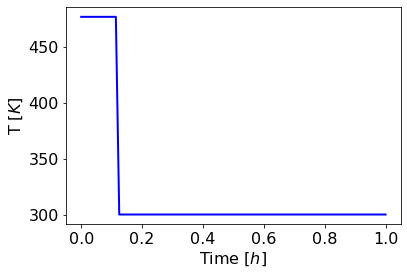

In [12]:
print('======Result summary======')
print('This optimization is solved with status:', optimize_result.status)
print('The result FIM is:', optimize_result.FIM)
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(optimize_result.trace))
print('D-optimality:', np.log10(optimize_result.det))
print('E-optimality:', np.log10(optimize_result.min_eig))
print('Modified E-optimality:', np.log10(optimize_result.cond))

t_list = []
for t in optimize_result.model.t:
    t_list.append(t)

T_list = []
for i in t_list:
    T_list.append(pyo.value(optimize_result.model.T[i]))
    
si=16
plt.rc('axes', titlesize=si)
plt.rc('axes', labelsize=si)
plt.rc('xtick', labelsize=si)
plt.rc('ytick', labelsize=si)
plt.rc('legend', fontsize=12)
plt.plot(t_list, T_list, 'b', linewidth=2)
#plt.scatter(t_list, T_list, 'b')
plt.ylabel('T [$K$]')
plt.xlabel('Time [$h$]')
plt.show()

## Method: Exploratory analysis (Enumeration)

This method conducts exploratory analysis by enumeration. 
It allows a user to define any number (dimensions) of design variables.
Heatmaps can be drawn by two design variables, fixing other design variables; 
1D curve can be drawn by one design variable, fixing other design variables.

### Specify user inputs

In [13]:
# Design variable ranges as lists 
design_ranges = [list(np.linspace(1,5,5)), list(np.linspace(300,700,5))]

# Design variable names 
dv_apply_name = ['CA0','T']

# Design variable should be fixed at these time points
dv_apply_time = [[0],t_control]

# Define experiments. This is a starting point of which the value does not matter
exp1 = generate_exp(t_control, 5, [300, 300, 300, 300, 300, 300, 300, 300, 300])
    
## choose from 'sequential_finite', 'direct_kaug'
#sensi_opt = 'sequential_finite'
sensi_opt = 'direct_kaug'

# model option
if sensi_opt == 'direct_kaug':
    args_ = [False]
else:
    args_ = [True]

In [14]:
# add prior information
prior_5_300 = pd.read_csv('fim_5_300_scale.csv')

prior_all = prior_5_300

prior_pass=np.asarray(prior_all)

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))

The prior information FIM: [[  22.52943024    1.84034314  -70.23273336  -11.09432962]
 [   1.84034314   18.09848116   -5.73565034 -109.15866135]
 [ -70.23273336   -5.73565034  218.94192843   34.57680848]
 [ -11.09432962 -109.15866135   34.57680848  658.37644634]]
Prior Det: 1.8919381570733835e-08


In [15]:
doe_object = doe.DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=args_)

all_fim = doe_object.run_grid_search(exp1, design_ranges, dv_apply_name, dv_apply_time, 
                                     mode=sensi_opt)

25  design vectors will be searched.
=======This is the  1 th iteration=======
Design variable values of this iteration: {'CA0': {0: 1.0}, 'T': {0: 300.0, 0.125: 300.0, 0.25: 300.0, 0.375: 300.0, 0.5: 300.0, 0.625: 300.0, 0.75: 300.0, 0.875: 300.0, 1: 300.0}}
After practice: {'C_index_CA': [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1], 'C_index_CB': [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1], 'C_index_CC': [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]}
The variable is fixed: C[0,CB,0]
The variable is fixed: C[0,CC,0]
Build time with direct kaug mode [s]: 0.006206512451171875
Solve time with direct kaug mode [s]: 0.7367784976959229
Total wall clock time [s]: 0.8370568752288818
Existed information has been added.
FIM: [[  22.52955557    1.84034548  -70.23699396  -11.09467773]
 [   1.84034548   18.09848639   -5.73572975 -109.15944213]
 [ -70.23699396   -5.73572975  219.08676025   34.5886419 ]
 [ -11.09467773 -109.15944213   34.5886419   658.49280169]]
Trace: 918.20760

The variable is fixed: C[0,CB,0]
The variable is fixed: C[0,CC,0]
Build time with direct kaug mode [s]: 0.008573770523071289
Solve time with direct kaug mode [s]: 0.755335807800293
Total wall clock time [s]: 0.8380696773529053
Existed information has been added.
FIM: [[  22.52968654    1.84037716  -70.2392677   -11.0981322 ]
 [   1.84037716   18.09850616   -5.73651773 -109.16145565]
 [ -70.2392677    -5.73651773  219.10852132   34.67375526]
 [ -11.0981322  -109.16145565   34.67375526  658.68876112]]
Trace: 918.4254751324311
Determinant: 11.886865066068328
Condition number: 132866.61740479886
Minimal eigen value: 0.005117063516118062
Eigen values: [6.79886920e+02 2.38519113e+02 1.43247369e-02 5.11706352e-03]
Eigen vectors: [[ 0.02559113 -0.30421087  0.82133246 -0.4818857 ]
 [ 0.16291962  0.01375479  0.49924781  0.85089343]
 [-0.07990535  0.94890251  0.26329119 -0.15452154]
 [-0.98306532 -0.08276822  0.08271853  0.14103064]]
This is the  8  run out of  25 run.
The code has run 6.4831 sec

The variable is fixed: C[0,CB,0]
The variable is fixed: C[0,CC,0]
Build time with direct kaug mode [s]: 0.004711151123046875
Solve time with direct kaug mode [s]: 0.970649242401123
Total wall clock time [s]: 1.0465233325958252
Existed information has been added.
FIM: [[  22.52973816    1.84038394  -70.23901379  -11.09797782]
 [   1.84038394   18.09850281   -5.73648252 -109.16059747]
 [ -70.23901379   -5.73648252  219.0700239    34.65121728]
 [ -11.09797782 -109.16059747   34.65121728  658.54956368]]
Trace: 918.2478285490197
Determinant: 4.199901155447992
Condition number: 262709.5710674252
Minimal eigen value: 0.002587451704761356
Eigen values: [6.79748328e+02 2.38486901e+02 1.00127677e-02 2.58745170e-03]
Eigen vectors: [[ 0.02559307 -0.30425314  0.85496389 -0.41929913]
 [ 0.16295173  0.01374332  0.43440872  0.88574653]
 [-0.07987507  0.94889146  0.27412198 -0.13446975]
 [-0.98306241 -0.08274149  0.07199268  0.14683051]]
This is the  14  run out of  25 run.
The code has run 12.2823 sec

The variable is fixed: C[0,CB,0]
The variable is fixed: C[0,CC,0]
Build time with direct kaug mode [s]: 0.0035431385040283203
Solve time with direct kaug mode [s]: 0.7940301895141602
Total wall clock time [s]: 0.8640820980072021
Existed information has been added.
FIM: [[  22.529767      1.84039364  -70.23845713  -11.09809245]
 [   1.84039364   18.09850036   -5.73650866 -109.16009234]
 [ -70.23845713   -5.73650866  219.0392134    34.6407641 ]
 [ -11.09809245 -109.16009234   34.6407641   658.4830726 ]]
Trace: 918.1505533564896
Determinant: 1.4314064773298625
Condition number: 557201.5242193353
Minimal eigen value: 0.0012198137382687635
Eigen values: [6.79682074e+02 2.38460019e+02 7.24015839e-03 1.21981374e-03]
Eigen vectors: [[ 0.02559408 -0.30428631  0.85297217 -0.42331225]
 [ 0.16296696  0.01373765  0.43856842  0.88369157]
 [-0.07985913  0.94888213  0.2735181  -0.13576842]
 [-0.98306115 -0.08272736  0.07269159  0.14650216]]
This is the  20  run out of  25 run.
The code has run 17.8962

The variable is fixed: C[0,CB,0]
The variable is fixed: C[0,CC,0]
Build time with direct kaug mode [s]: 0.005528450012207031
Solve time with direct kaug mode [s]: 0.8269145488739014
Total wall clock time [s]: 0.9072766304016113
Existed information has been added.
FIM: [[  22.52976247    1.84039137  -70.23757357  -11.09740992]
 [   1.84039137   18.09849447   -5.73635297 -109.15951195]
 [ -70.23757357   -5.73635297  219.01244333   34.62168412]
 [ -11.09740992 -109.15951195   34.62168412  658.43077211]]
Trace: 918.0714723901549
Determinant: 0.3725498293676709
Condition number: 1411477.3686387218
Minimal eigen value: 0.0004815012636207069
Eigen values: [6.79628137e+02 2.38438080e+02 4.77463274e-03 4.81501264e-04]
Eigen vectors: [[ 0.02559122 -0.30431362  0.86983852 -0.38745227]
 [ 0.1629792   0.0137228   0.40141602  0.90117403]
 [-0.07982281  0.94887651  0.27895918 -0.12427174]
 [-0.98306215 -0.08269387  0.06654247  0.14940761]]
This is the  26  run out of  25 run.
The code has run 23.5898

### 1D sensitivity curve

Design variable:  ['CA0', 'T']
Value          :  (1.0, 300.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 400.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 500.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 600.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 700.0)
Design variable:  ['CA0', 'T']
Value          :  (2.0, 300.0)
Design variable:  ['CA0', 'T']
Value          :  (2.0, 400.0)
Design variable:  ['CA0', 'T']
Value          :  (2.0, 500.0)
Design variable:  ['CA0', 'T']
Value          :  (2.0, 600.0)
Design variable:  ['CA0', 'T']
Value          :  (2.0, 700.0)
Design variable:  ['CA0', 'T']
Value          :  (3.0, 300.0)
Design variable:  ['CA0', 'T']
Value          :  (3.0, 400.0)
Design variable:  ['CA0', 'T']
Value          :  (3.0, 500.0)
Design variable:  ['CA0', 'T']
Value          :  (3.0, 600.0)
Design variable:  ['CA0', 'T']
Value          :  (3.0, 700.0)
Design variable:  ['CA0', 'T']
Value          :  (4.0, 300.0)
Design v

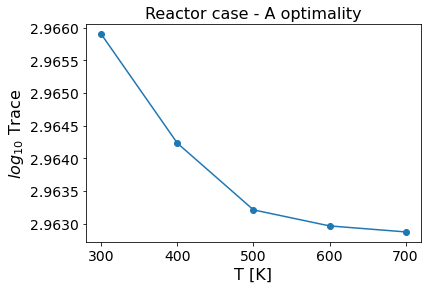

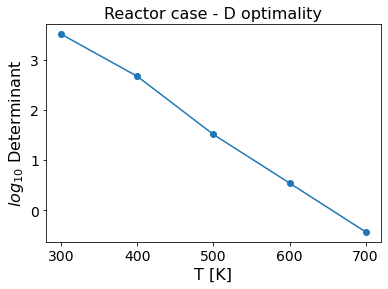

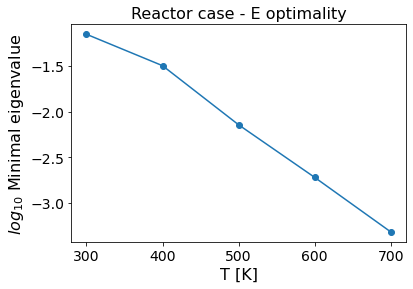

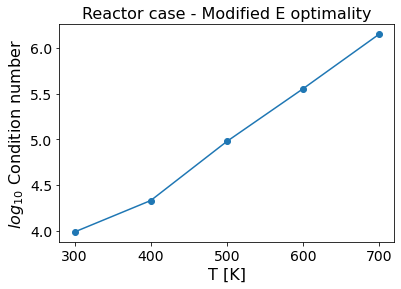

In [16]:
test = all_fim.extract_criteria()

## draw 1D sensitivity curve 

fixed = {"'CA0'": 5.0}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )



## Heatmap

2D heatmap is plotted with  ['CA0', 'T'] .


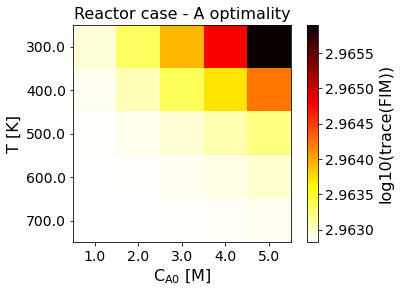

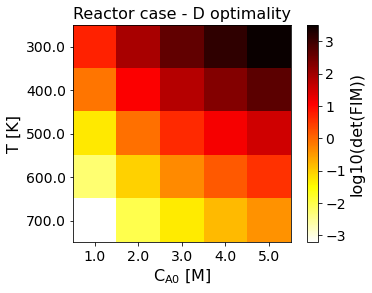

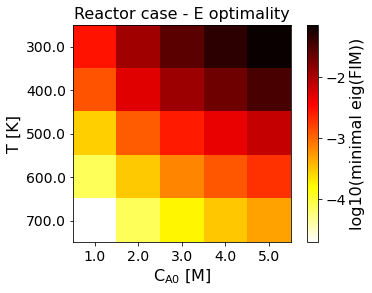

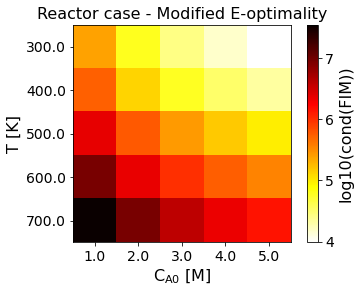

In [17]:
fixed = {}
all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )

## Grid search for 3 design variables

In [ ]:

# Define design ranges
design_ranges = [list(np.linspace(1,5,2)),  list(np.linspace(300,700,2)), [300,500]]

# Define design variable 
# Here the two T are for different controlling time subsets
dv_apply_name = ['CA0', 'T', 'T']
dv_apply_time = [[0], [0], [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875,1]]

# Define experiments
exp1 = generate_exp(t_control, 5, [300, 300, 300, 300, 300, 300, 300, 300, 300])

## choose from 'sequential_finite', 'direct_kaug'
#sensi_opt = 'sequential_finite'
sensi_opt = 'direct_kaug'

# model option
if sensi_opt == 'direct_kaug':
    args_ = [False]
else:
    args_ = [True]

In [ ]:
doe_object = doe.DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=args_)

all_fim = doe_object.run_grid_search(exp1, design_ranges, dv_apply_name, dv_apply_time, 
                                     mode=sensi_opt)

### Draw 1D sensitivity curve

In [ ]:
test = all_fim.extract_criteria()

In [ ]:
## draw 1D sensitivity curve 

fixed = {"'CA0'": 1.0, "'T2'": 300}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )

### Draw 2D sensitivity curve

In [ ]:
fixed = {"'T2'": 300}

all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )